# 1.2 Neural network basics

In this notebook, we construct a basic neural network in PyTorch. We attempt to only provide a bare-bone example for clarity. For another such example, please see [PyTorch's homepage](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

<!--
- [Building the network](#Building-the-network)
- [Training the network](#Training-the-network)
- [Testing the network](#Testing-the-network)
- [Exercises](#Exercises)
-->

First, we import the libraries and load the data. You have already seen this code in notebook 1.1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [23]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# We load a training set
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# And withhold some data for testing
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=32, pin_memory=True) # Torch's default dataloader is sequential and slow. Use num_worker may speed up the process a bit, but still CPU-driven. Write own loader if data fits on GPU
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False,num_workers=32, pin_memory=True)

## Building the network

Below, we construct a fully connected neural network. Here, we will limit ourselves to a single hidden layer, i.e., it's a shallow rather than deep neural network. To construct a neural network in PyTorch, we define a class that inherits from the nn.Module class. 

The class contains two functions:

1) init: Defines all the objects we will need.

2) forward: puts all of these objects together, defining the network architecture. Basically, x starts out as your input tensor and is transformed step by step as it passes through each layer of the network. In this notebook, we consider MNIST images as our input tensors. Each image contains 28x28 pixels. The fully connected layers of the neural network, however, can only deal with one-dimensional feature vectors. So, we flatten the tensor, x, which is then passed on to the first fully connected layer, fc1. After the first fully connected layer, a Rectified Linear Unit (ReLU) activation function is applied element-wise to the tensor. The tensor is then passed through the second fully connected layer, fc2. After passing through the second fully connected layer, the transformed x is returned. The final tensor (x) represents the output of the neural network, which can be used for tasks like classification (you can rename x if you don't want to call the input and the output the same or if you want to distinguish between feature extraction and the final classification).

In [24]:
# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

You can now create an instance of the class.

In [25]:
model = SimpleNet()
model = model.to(device)

## Training the network

We now want to train the weights of the neural network. For this purpose, we first need to define what a good fit to data entails.

In [26]:
criterion = nn.CrossEntropyLoss().to(device)

Secondly, we need to decide how we want to optimise the network.

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

Now, we are ready to train the neural network. Let's train for 5 epochs. Note that fixing the number of epochs in this manner is not a good choice and will lead to under- or overfitting. But in this notebook, we merely want to understand the basic concepts behind training a neural network.

In each epoch, for each batch from the training set, we

1) clear the accumulated gradients of the model parameters (accumulated during backpropagation),

2) perform a forward run (i.e. we predict labels for the batch of images),

3) compute the loss for these predictions,

3) perform backpropagation,

5) and use this to optimise the weights and biases of our model.

In [ ]:
num_epochs = 500

# Training loop 
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    # !!!!!!!!!!!!!!!!!!!!! IMPORTANT !!!!!!!!!!!!!!!!!!!!!
    for images, labels in train_loader:
        images = images.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        labels = labels.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        for param in model.parameters():
            param.grad = None
        # optimizer.zero_grad() # zero the parameter gradients
        # outputs = model(images) #.to("cpu") # forward run
        # loss = criterion(outputs, labels) # compare to ground truth
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            outputs = model(images)
            loss = criterion(outputs, labels) 
        writer.add_scalar('Loss/train', loss, epoch)
        loss.backward() # back propagation
        optimizer.step() # update weights and biases
        
        running_loss += loss.item()
    # !!!!!!!!!!!!!!!!!!!!! IMPORTANT !!!!!!!!!!!!!!!!!!!!!
    # Print average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}')

writer.flush()

Epoch [1/500], Loss: 0.14813150471829353
Epoch [2/500], Loss: 0.1485662338105922
Epoch [3/500], Loss: 0.1443791460642155
Epoch [4/500], Loss: 0.1359356439018503
Epoch [5/500], Loss: 0.1328628104576405
Epoch [6/500], Loss: 0.13048275499901874
Epoch [7/500], Loss: 0.12598259422056218
Epoch [8/500], Loss: 0.12325031424456455
Epoch [9/500], Loss: 0.12934439190207644
Epoch [10/500], Loss: 0.12137994424618305
Epoch [11/500], Loss: 0.11353505360002214
Epoch [12/500], Loss: 0.11586436912258889
Epoch [13/500], Loss: 0.12071263809153374
Epoch [14/500], Loss: 0.1127504761152445
Epoch [15/500], Loss: 0.11715948677601966
Epoch [16/500], Loss: 0.10989731203843939
Epoch [17/500], Loss: 0.11211614618276028
Epoch [18/500], Loss: 0.11359295153078881
Epoch [19/500], Loss: 0.10897403921377151
Epoch [20/500], Loss: 0.10302586025221551
Epoch [21/500], Loss: 0.09980683736503124
Epoch [22/500], Loss: 0.10208247919031914
Epoch [23/500], Loss: 0.1032940223020442
Epoch [24/500], Loss: 0.10606647302654196
Epoch [

Exception ignored in: <function _releaseLock at 0x14ec70907ba0>
Traceback (most recent call last):
  File "/usr/lib64/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch [68/500], Loss: 0.08294161748775142
Epoch [69/500], Loss: 0.07929779395381821
Epoch [70/500], Loss: 0.08154240816118236
Epoch [71/500], Loss: 0.08083965115724726
Epoch [72/500], Loss: 0.08285128651781284
Epoch [73/500], Loss: 0.08491711384478084
Epoch [74/500], Loss: 0.0699440359118137
Epoch [75/500], Loss: 0.0687047216565685
Epoch [76/500], Loss: 0.07984105956919016


## Testing the network

Having trained the network, we can now test it on unseen data (the test set).

In [8]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        labels = labels.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy}%')

Accuracy on the test set: 95.3%


That's a pretty high accuracy, reflecting that the MNIST dataset is relatively simple and well-behaved. Indeed, you can do much better. CNNs can reach an accuracy of more than 99 per cent (see [Kaggle](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)). To achieve such a high accuracy, we need to improve the architecture. We will do so in notebook 2.1.

## Exercises

**Exercise 1**: Here, we use the adam optimiser. Find out what other optimisers are available.

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)

**Exercise 2**: What do the hyperparameters (e.g. lr in adam) mean? Change lr to a higher value (e.g. 1) and rerun the notebook. Or to a lower value. What happens? Why?

lr = Learning rate; how big each optimisation step is

**Exercise 3**: Here, we use the cross entropy as the loss function. What is a loss function? And what is the cross entropy?

Other loss functions include MSE (for continuous target), ...

**Exercise 4**: Integrate data augmentation techniques into the data preprocessing pipeline. This helps improve the model's generalisation.


**Exercise 5**: Change the architecture of the neural network. Add more layers, increase the number of neurons, or try a different activation function. 

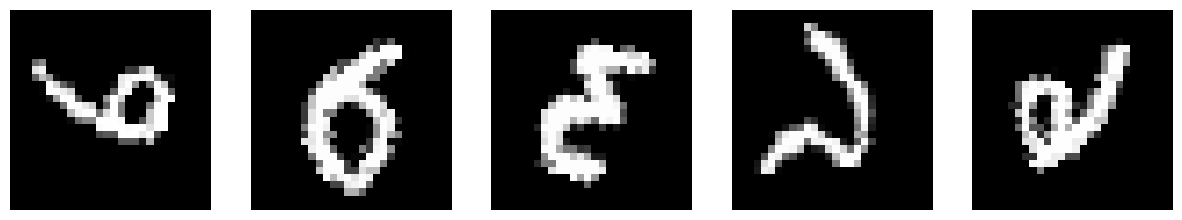

In [2]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=(-90, 90)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# We load a training set
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# And withhold some data for testing
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=32, pin_memory=True) # Torch's default dataloader is sequential and slow. Use num_worker may speed up the process a bit, but still CPU-driven. Write own loader if data fits on GPU
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False,num_workers=32, pin_memory=True)

# Get the first batch from the data loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].permute(1, 2, 0)
    axes[i].imshow(img, cmap="gray")
    axes[i].axis('off')
    


In [9]:
# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(28 * 28, 28*28)
        self.fce = nn.Linear(28 * 28, 28*28*4)
        self.fcc1 = nn.Linear(28*28*4, 28*28)
        self.fcc2 = nn.Linear(28*28, 14*14)
        self.fcc3 = nn.Linear(14*14, 7*7)
        self.fcf = nn.Linear(7*7, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        # x = self.fc0(x)
        # x = self.relu(x)
        # x = self.fce(x)
        # x = self.relu(x)
        # x = self.fcc1(x)
        # x = self.relu(x)
        x = self.fcc2(x)
        x = self.relu(x)
        x = self.fcc3(x)
        x = self.relu(x)
        x = self.fcf(x)
        return x
    
model = SimpleNet()
model = model.to(device)

More parameters does not mean better! (It does not give less loss at all!)

In [14]:
# Criterion
criterion = nn.CrossEntropyLoss().to(device)
# Optimiser
optimizer = optim.SGD(model.parameters(), lr=0.0001)

num_epochs = 205

# Training loop 
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    # !!!!!!!!!!!!!!!!!!!!! IMPORTANT !!!!!!!!!!!!!!!!!!!!!
    for images, labels in train_loader:
        images = images.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        labels = labels.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        for param in model.parameters():
            param.grad = None
        # optimizer.zero_grad() # zero the parameter gradients
        # outputs = model(images) #.to("cpu") # forward run
        # loss = criterion(outputs, labels) # compare to ground truth
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            outputs = model(images)
            loss = criterion(outputs, labels) 
        writer.add_scalar('Loss/train', loss, epoch)
        loss.backward() # back propagation
        optimizer.step() # update weights and biases
        
        running_loss += loss.item()
    # !!!!!!!!!!!!!!!!!!!!! IMPORTANT !!!!!!!!!!!!!!!!!!!!!
    # Print average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}')

writer.flush()

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        labels = labels.to(device, non_blocking=True) # SLOW!! # Move data from CPU to the GPU in parallel by num_workers in the DataLoader
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy}%')

Epoch [1/205], Loss: 0.5220371238728787
Epoch [2/205], Loss: 0.504475899199222
Epoch [3/205], Loss: 0.4961781860666072
Epoch [4/205], Loss: 0.4843355842093204
Epoch [5/205], Loss: 0.4817128670342425
Epoch [6/205], Loss: 0.4801069362366453
Epoch [7/205], Loss: 0.47565597536716053
Epoch [8/205], Loss: 0.47690476711760177
Epoch [9/205], Loss: 0.47796816876594056
Epoch [10/205], Loss: 0.47175676264661426
Epoch [11/205], Loss: 0.468575442217766
Epoch [12/205], Loss: 0.4694708157092967
Epoch [13/205], Loss: 0.47089943733621153
Epoch [14/205], Loss: 0.46915886047038624
Epoch [15/205], Loss: 0.4675324727880194
Epoch [16/205], Loss: 0.46744457153563806
Epoch [17/205], Loss: 0.4666035890579224
Epoch [18/205], Loss: 0.46695321043755145
Epoch [19/205], Loss: 0.46682304917497836
Epoch [20/205], Loss: 0.4666269654923297
Epoch [21/205], Loss: 0.4670950729796227
Epoch [22/205], Loss: 0.4654168178426458
Epoch [23/205], Loss: 0.4612982332706451
Epoch [24/205], Loss: 0.4644249596494309
Epoch [25/205], Lo

Exception ignored in: <function _releaseLock at 0x15379356bba0>
Traceback (most recent call last):
  File "/usr/lib64/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch [148/205], Loss: 0.4401644915976423
Epoch [149/205], Loss: 0.43586913087266554
Epoch [150/205], Loss: 0.4383368560608397
Epoch [151/205], Loss: 0.43664550020339643
Epoch [152/205], Loss: 0.43943516738871313
Epoch [153/205], Loss: 0.4402377355605998
Epoch [154/205], Loss: 0.44007655191928785
Epoch [155/205], Loss: 0.44024184333517197
Epoch [156/205], Loss: 0.44071899931481545
Epoch [157/205], Loss: 0.440718027885924
Epoch [158/205], Loss: 0.43817619021902693
Epoch [159/205], Loss: 0.43682895746636896
Epoch [160/205], Loss: 0.43746686425614867
Epoch [161/205], Loss: 0.4348398743791783
Epoch [162/205], Loss: 0.44014533770845293
Epoch [163/205], Loss: 0.4389417681288212
Epoch [164/205], Loss: 0.4373082721487005
Epoch [165/205], Loss: 0.43903535870795557
Epoch [166/205], Loss: 0.43815749414423677
Epoch [167/205], Loss: 0.4391647141030494
Epoch [168/205], Loss: 0.43397418349347217
Epoch [169/205], Loss: 0.4378836865120746
Epoch [170/205], Loss: 0.4390276954529133
Epoch [171/205], Loss: